In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df_iemocap = pd.read_csv(r'/kaggle/input/iemocap-three-values-spectrogram/df_iemocap.csv')

spectrogram_dir = '/kaggle/input/processed-spectrograms'

In [3]:
images = []
labels = []

for _, row in df_iemocap.iterrows():
    file_name = row['wav_file']
    spectrogram_path = os.path.join(spectrogram_dir, f"{file_name}.png")
    
    if os.path.exists(spectrogram_path):
        img = load_img(spectrogram_path, color_mode='grayscale', target_size=(128, 128))
        img_array = img_to_array(img) / 255.0  # Normalize image
        
        images.append(img_array)
        labels.append([row['val'], row['act'], row['dom']])

images = np.array(images)
labels = np.array(labels)

In [4]:

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),  
        layers.Dense(128, activation='relu'),
        
        layers.Dense(3, activation='linear')  
    ])
    
    return model


In [5]:
input_shape = (128, 128, 1)  
model = create_cnn_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 189s 743ms/step - loss: 1.2957 - mae: 0.8560 - val_loss: 0.5570 - val_mae: 0.6005
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 184s 734ms/step - loss: 0.6770 - mae: 0.6570 - val_loss: 0.5728 - val_mae: 0.5941
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 201s 731ms/step - loss: 0.6105 - mae: 0.6240 - val_loss: 0.5280 - val_mae: 0.5870
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 183s 730ms/step - loss: 0.5673 - mae: 0.6021 - val_loss: 0.5761 - val_mae: 0.6142
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 185s 736ms/step - loss: 0.5767 - mae: 0.6089 - val_loss: 0.5916 - val_mae: 0.6104
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 183s 729ms/step - loss: 0.5604 - mae: 0.5970 - val_loss: 0.5156 - val_mae: 0.5793
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 184s 734ms/step - loss: 0.5480 - mae: 0.5901 - val_loss: 0.5106 - val_mae: 0.5669
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 182s 724ms/step - loss: 0.5236 - mae: 0.5757 - val_loss: 0.4940 - val_mae: 0.5572
Epoch 9/20
251/251 ━━━━━

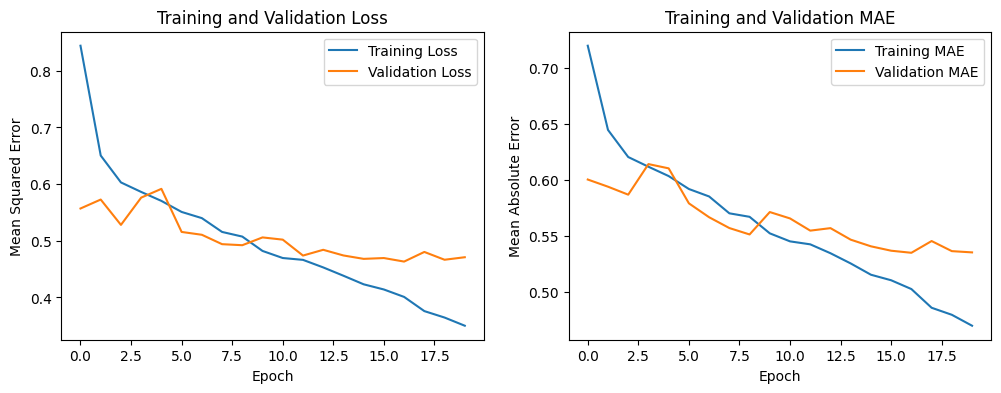

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.4713 - mae: 0.5344
Test Loss: 0.4709621071815491
Test MAE: 0.5355525016784668
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step
Predicted: [3.5367835 3.1472912 3.1572657], True: [4.  3.  3.5]
Predicted: [3.1146548 3.119262  3.2402005], True: [2.  2.5 4. ]
Predicted: [3.0650995 2.8502047 3.023014 ], True: [4. 3. 3.]
Predicted: [2.0276372 3.475546  3.6408515], True: [1.5 3.5 3. ]
Predicted: [2.945894  2.7374027 2.8755517], True: [2.  3.  3.5]


In [6]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss')

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = model.predict(X_test)

for i in range(5):
    print(f"Predicted: {predictions[i]}, True: {y_test[i]}")


In [7]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = model.predict(X_test)

for i in range(5):
    print(f"Predicted: {predictions[i]}, True: {y_test[i]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.4713 - mae: 0.5344
Test Loss: 0.4709621071815491
Test MAE: 0.5355525016784668
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step
Predicted: [3.5367835 3.1472912 3.1572657], True: [4.  3.  3.5]
Predicted: [3.1146548 3.119262  3.2402005], True: [2.  2.5 4. ]
Predicted: [3.0650995 2.8502047 3.023014 ], True: [4. 3. 3.]
Predicted: [2.0276372 3.475546  3.6408515], True: [1.5 3.5 3. ]
Predicted: [2.945894  2.7374027 2.8755517], True: [2.  3.  3.5]


In [8]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse}")

# Calculate Accuracy (Mean Absolute Percentage Error - MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(y_test, predictions)
print(f"Test MAPE: {mape}%")

Test RMSE: 0.6862667724305448
Test MAPE: 20.101567749118054%


In [10]:
model.save('cnn_model_alt.h5')
